# Google ColaboratoryでChainerRLを実行してみる

今回実行するのは、ChainerRLの[QuickStart](https://colab.research.google.com/drive/1XQaqLeUpn299ZdDDJ7CtGtJkZ0A-Tgii)を実行する。

In [1]:
# ChainerRLとgymのインストール
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip -q install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install chainerrl
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'
    100% |████████████████████████████████| 205.2MB 150kB/s 
    100% |████████████████████████████████| 92kB 7.6MB/s 


In [0]:
import gym
import numpy as np

In [3]:
# CartPoleの実行
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation = env.reset()
#env.render()
print('initial observation:', observation)

action = env.action_space.sample()
observation, reward, done, info = env.step(action)
print('next observation:', observation)
print('reward:', reward)
print('done:', done)
print('info:', info)

observation space: Box(4,)
action space: Discrete(2)
initial observation: [ 0.01109452 -0.04161109 -0.00984858 -0.03204958]
next observation: [ 0.0102623  -0.23659043 -0.01048957  0.25750982]
reward: 1.0
done: False
info: {}


In [0]:
# Q関数クラスの実装
import chainerrl

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

q_func = chainerrl.q_functions.FCStateQFunctionWithDiscreteAction(
    obs_size, n_actions,
    n_hidden_layers=2, n_hidden_channels=50)

In [0]:
# Q関数クラスの実装(chainerで実装する場合)
import chainer
import chainer.functions as F
import chainer.links as L

class QFunction(chainer.Chain):

    def __init__(self, obs_size, n_actions, n_hidden_channels=50):
        super().__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_hidden_channels)
            self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)
            self.l2 = L.Linear(n_hidden_channels, n_actions)

    def __call__(self, x, test=False):
        """
        Args:
            x (ndarray or chainer.Variable): An observation
            test (bool): a flag indicating whether it is in test mode
        """
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l1(h))
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))

_q_func = QFunction(obs_size, n_actions)

In [6]:
# optimizerの設定
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

In [0]:
# DQNエージェントの作成
# 将来の報酬に対する割引率
gamma = 0.95

# 探索にはε-グリーディー法を使用する
explorer = chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample)

replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

# CartPole-v0はnumpy.float64だが、Chainerはnumpy.float32しか受け付けない
phi = lambda x: x.astype(np.float32, copy=False)

# エージェント
agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

In [8]:
# 訓練開始
n_episodes = 200
max_episode_len = 200
for i in range(1, n_episodes + 1):
    observation = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(observation, reward)
        observation, reward, done, _ = env.step(action)
        R += reward
        t += 1
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(observation, reward, done)
print('Finished.')

episode: 10 R: 35.0 statistics: [('average_q', -0.001221060533673519), ('average_loss', 0), ('n_updates', 0)]
episode: 20 R: 13.0 statistics: [('average_q', 0.304417454887287), ('average_loss', 0.23270589418679252), ('n_updates', 226)]
episode: 30 R: 10.0 statistics: [('average_q', 0.7582338496701959), ('average_loss', 0.21796105659341072), ('n_updates', 330)]
episode: 40 R: 13.0 statistics: [('average_q', 1.2867077555637505), ('average_loss', 0.2652617549567077), ('n_updates', 443)]
episode: 50 R: 8.0 statistics: [('average_q', 1.9454131135244324), ('average_loss', 0.29347376066085734), ('n_updates', 561)]
episode: 60 R: 14.0 statistics: [('average_q', 2.7157613239817224), ('average_loss', 0.4001728056045107), ('n_updates', 698)]
episode: 70 R: 12.0 statistics: [('average_q', 3.4782917409149054), ('average_loss', 0.4312676031560555), ('n_updates', 822)]
episode: 80 R: 10.0 statistics: [('average_q', 4.18164967626042), ('average_loss', 0.45969273582477976), ('n_updates', 935)]
episode:

In [0]:
# env.render()を実行するための仮想ディスプレイの設定
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

test episode's R: 10.0


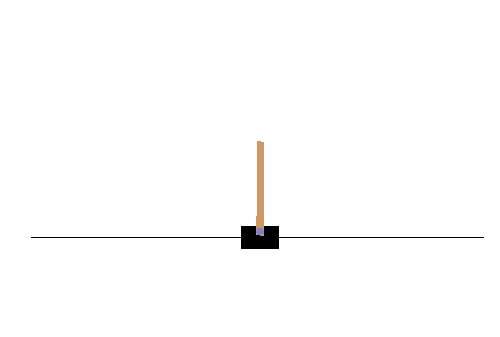

In [10]:
# 訓練されたモデルでテスト実行
frames = []
observation = env.reset()
done = False
R = 0
t = 0
while not done and t < 200:
    frames.append(env.render(mode = 'rgb_array'))
    action = agent.act(observation)
    observation, reward, done, _ = env.step(action)
    R += reward
    t += 1
print('test episode\'s R:', R)
agent.stop_episode()
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

In [11]:
# Google Driveに動画を出力するために、マウントする
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
# wrap env for recording video
out = '/content/gdrive/My Drive/Colab Notebooks/logs/cart_pole_v0'
envw = gym.wrappers.Monitor(env, out, force=True)

observation = envw.reset()
done = False
R = 0
t = 0
while not done and t < 200:
    envw.render()
    action = agent.act(observation)
    observation, reward, done, _ = envw.step(action)
    R += reward
    t += 1
print('test episode \'s R:', R)
agent.stop_episode()

test episode 's R: 11.0


In [0]:
# エージェントの保存
out = '/content/gdrive/My Drive/Colab Notebooks/logs/cart_pole_v0'

agent.save(out)